In [1]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [2]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 21.2 MB/s 
     |████████████████████████████████| 181 kB 77.3 MB/s 
     |████████████████████████████████| 157 kB 66.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 62.0 MB/s 
     |████████████████████████████████| 157 kB 64.2 MB/s 
     |████████████████████████████████| 157 kB 68.3 MB/s 
     |████████████████████████████████| 157 kB 60.8 MB/s 
     |████████████████████████████████| 156 kB 60.0 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time

## Data 

In [4]:
#---# UNZIP #---#
# !unzip -qq "180219_Signal Modulation Test_Abnormal_01.zip"

# !unzip -qq "180220_Signal Modulation Test_Abnormal_01.zip"
# !unzip -qq "180220_Signal Modulation Test_Normal_00.zip"

# !unzip -qq "180221_Signal Modulation Test_Abnormal_01.zip"
# !unzip -qq "180221_Signal Modulation Test_Normal_00.zip"

# !unzip -qq "180222_Signal Modulation Test_Abnormal_01.zip"
# !unzip -qq "180222_Signal Modulation Test_Normal_00.zip"

#---# Road original data #---#
# data_20 = pd.read_csv('180220_Signal Modulation Test_Normal_00_5_100ms_sujeong.csv', skiprows=[1,2], header=0)

# data_21_ab = pd.read_csv('180221_Signal Modulation Test_Abnormal_01_5_100ms_sujeong.csv', skiprows=[1,2], header=0)
# data_21 = pd.read_csv('180221_Signal Modulation Test_Normal_00_5_100ms_sujeong.csv', skiprows=[1,2], header=0)

# data_22_ab = pd.read_csv('180222_Signal Modulation Test_Abnormal_01_5_100ms_sujeong.csv', skiprows=[1,2], header=0)
# data_22 = pd.read_csv('180222_Signal Modulation Test_Normal_00_5_100ms_sujeong.csv', skiprows=[1,2], header=0)

data_20 = pd.read_csv('180220_Signal Modulation Test_Normal_00_5_10ms_sujeong.csv', skiprows=[1,2], header=0)

data_21_ab = pd.read_csv('180221_Signal Modulation Test_Abnormal_01_5_10ms_sujeong.csv', skiprows=[1,2], header=0)
data_21 = pd.read_csv('180221_Signal Modulation Test_Normal_00_5_10ms_sujeong.csv', skiprows=[1,2], header=0)

data_22_ab = pd.read_csv('180222_Signal Modulation Test_Abnormal_01_5_10ms_sujeong.csv', skiprows=[1,2], header=0)
data_22 = pd.read_csv('180222_Signal Modulation Test_Normal_00_5_10ms_sujeong.csv', skiprows=[1,2], header=0)

#---# Plotting #---#
# for i in range(1,252) :
#   plt.figure(figsize=(30,5))
#   plt.plot(data_21_ab.iloc[:,i]) # 70 column
#   print(i)
#   plt.show()

###  
###
'''
plt.figure(figsize=(30,5))
plt.plot(data22.iloc[:,70])
plt.show()
'''

Fu_p_20 = data_20.iloc[:,1].values
Fu_p_21 = data_21.iloc[:,1].values
Fu_p_21_ab = data_21_ab.iloc[:,1].values
Fu_p_22 = data_22.iloc[:,1].values
Fu_p_22_ab = data_22_ab.iloc[:,1].values

#---# SAVE npy file #---#
np.save('Fu_20_normal_10', Fu_p_20)
np.save('Fu_21_normal_10', Fu_p_21)
np.save('Fu_21_abnormal_10', Fu_p_21_ab)
np.save('Fu_22_normal_10', Fu_p_22)
np.save('Fu_22_abnormal_10', Fu_p_22_ab)

#---# 데이터 확인 #---#
print(data_22.shape, data_22_ab.shape, data_21.shape, data_21_ab.shape, data_20.shape)
print(set(data_22.columns) - set(data_21.columns))
plt.figure(figsize=(30,5))
plt.plot(data_22_ab[['Fu_uPMean\\ETKC:1']])
# plt.plot(data_21_ab[['Fu_uPMean\\ETKC:1']])

ParserError: ignored

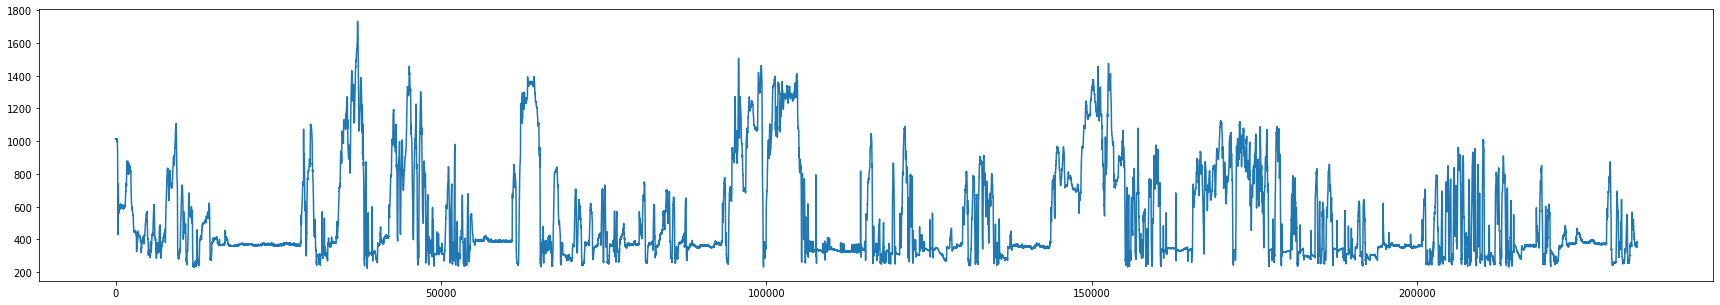

In [5]:
#---# LOAD npy file #---#
Fu_20_normal = np.load('Fu_20_normal.npy')
Fu_21_normal = np.load('Fu_21_normal.npy')
Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
Fu_22_normal = np.load('Fu_22_normal.npy')
Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

# import sys
# np.set_printoptions(threshold=sys.maxsize) # print all

#---# 확인용 #---#
plt.figure(figsize=(30,5))
plt.plot(Fu_22_abnormal_10)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class MyDataset(Dataset):
  def __init__(self, data):
    # self.data = data
    self.data = np.array(self.sliding_window(data, wandb.config.window_size, wandb.config.stride))
    self.data = self.data.reshape(-1, wandb.config.window_size)
    
  def __getitem__(self, index):
    self.x = self.data[index]
    return (index, torch.Tensor(self.x))
      
  def __len__(self):
    return len(self.data)

  #---# Window #---#
  def sliding_window(self, arr, window_size, stride):
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.Encoder = nn.Sequential(
      nn.Linear(wandb.config.window_size,150),
      nn.BatchNorm1d(150),
      nn.LeakyReLU(),
      nn.Linear(150,2),
      nn.BatchNorm1d(2)
      # nn.LeakyReLU(),
      # nn.Linear(200,100),
      # nn.BatchNorm1d(100),

      # nn.LeakyReLU(),
      # nn.Linear(100,50),
      # nn.BatchNorm1d(50),
      # nn.LeakyReLU()
    )
    self.Decoder = nn.Sequential(
      nn.Linear(2,150),
      nn.BatchNorm1d(150),
      nn.LeakyReLU(),
      # nn.Linear(100,200),
      # nn.BatchNorm1d(200),
      # nn.LeakyReLU(),
      # nn.Linear(200,400),
      # nn.BatchNorm1d(400),
      # nn.LeakyReLU(),
      nn.Linear(150,wandb.config.window_size),
    )

    #####
    # self.Encoder = nn.Sequential(
    #   nn.Linear(config.window_size, 2*config.window_size),
    #   nn.BatchNorm1d(2*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(2*config.window_size, 4*config.window_size),
    #   nn.BatchNorm1d(4*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(4*config.window_size, 8*config.window_size),
    #   nn.BatchNorm1d(8*config.window_size),
    #   nn.LeakyReLU()
    # )
    # self.Decoder = nn.Sequential(
    #   nn.Linear(8*config.window_size, 4*config.window_size),
    #   nn.BatchNorm1d(4*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(4*config.window_size, 2*config.window_size),
    #   nn.BatchNorm1d(2*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(2*config.window_size, config.window_size),
    # )
    
  def forward(self, x):
    x = self.Encoder(x)
    x = self.Decoder(x)
    return x

class Trainer():
  def __init__(self, model, optimizer, train_loader, scheduler, device):
    self.model = model
    self.optimizer = optimizer
    self.train_loader = train_loader
    self.scheduler = scheduler
    self.device = device
    # Loss Function
    self.criterion = nn.L1Loss().to(self.device) # L2도
      
  def fit(self) :
    self.model.to(self.device)
    best_score = 0
    for epoch in range(config.num_epochs):
      self.model.train()
      train_loss = []
      for idx, x in iter(self.train_loader):
        x = x.float().to(self.device)
        self.optimizer.zero_grad()
        
        _x = self.model(x)
        loss = self.criterion(x, _x)
        
        loss.backward()
        self.optimizer.step()

        train_loss.append(loss.item())

      wandb.log({
              "loss": loss
          })

      # score = self.validation(self.model, 0.95)
      # print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

      # if self.scheduler is not None: self.scheduler.step(score)

      # if best_score < score:
      #   best_score = score
      #   torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
  
  def test(self, test_loader, thr) :
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # eval_model.eval()
    pred = []; true = []
    xs = []; _xs = []
    predictions = []

    

    self.model.eval()
    with torch.no_grad():
      for idx, x in iter(test_loader):
        x = x.float().to(self.device)
        _x = self.model(x) # prediction
        
        xs.extend(torch.flatten(x).numpy().tolist()); _xs.extend(torch.flatten(_x).numpy().tolist())
        true.extend(torch.mean(x, dim=1).numpy().tolist()); pred.extend(torch.mean(_x, dim=1).numpy().tolist())

        #---# drawing
        # for i in range(config.batch_size) :
        #   a = x[i,:].reshape(1, -1)
        #   b = _x[i,:].reshape(1, -1)
        #   plt.figure(figsize=(30,5))
        #   plt.plot(x[i,:]) # 70 column
        #   plt.plot(_x[i,:], "r")
          
        #   # plt.vlines(anomal_idxs, -1, 2, colors="y")  
        #   plt.show()
        #   plt.clf()

        diff = cos(x, _x).cpu().tolist()
        prediction = np.where(np.array(diff) < thr, 1, 0).tolist() # 1, 0이 들어감
        predictions.extend(prediction)

        # plt.figure(figsize=(30,5))
        # plt.plot(true) # 70 column
        # plt.plot(pred, "r")
        # anomal_idxs = np.where(prediction == 1)
        # print("----", anomal_idxs)
        # plt.vlines(anomal_idxs, -0.5, 1.5, colors="y") 
        # plt.show()
        # plt.clf()

        # true += y.tolist()

    # print("===========----", predictions, sum(predictions))
    # plt.figure(figsize=(30,5))
    # plt.plot(xs)
    # plt.plot(_xs, "r")
    # for i in range(len(predictions)):
    #   if pred[i] == 1:
    #     plt.vlines(i * config.window_size, -0.5, 1.5, colors="y")
    #     plt.vlines((i+1) * config.window_size, -0.5, 1.5, colors="y")
    # plt.show()
    # plt.clf()
        
    return predictions, xs, _xs
    # return f1_score(true, pred, average='macro')

def drawing(pred, x, _x) :
  #---# Drawing - 22 #---#
  print("anomaly로 판단되는 구간의 개수 :", sum(pred))
  plt.figure(figsize=(30,5))
  plt.plot(x)
  # plt.plot(_x, "r")
  for i in range(len(pred)):
    if pred[i] == 1:
      # plt.vlines(i * config.window_size, -1, 4, colors="y")
      # plt.vlines((i+1) * config.window_size, -1, 4, colors="y")
      before = i * wandb.config.window_size
      after = (i+1) * wandb.config.window_size

      r = np.linspace(before, after)
      plt.fill_between(r, -1, 4, color = "yellow", alpha = 0.5)

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65200)
  plt.fill_between(a, -1, 4, color='red', alpha=0.5)
  b = np.linspace(95600, 99200)
  plt.fill_between(b, -1, 4, color='red', alpha=0.5)
  c = np.linspace(148400, 152200)
  plt.fill_between(c, -1, 4, color='red', alpha=0.5)

  plt.show()
  plt.clf()

In [9]:
def main() :
  tm = time.localtime(time.time())
  string = time.strftime('%Y%m%d_%H%M%S', tm)

  # wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)

  #---# Noramlize #---#
  scaler = StandardScaler()
  # total 먼저 해놓고 transform
  Fu_22_normal = scaler.fit_transform(Fu_22_normal_10.reshape(-1,1))
  Fu_22_abnormal = scaler.fit_transform(Fu_22_abnormal_10.reshape(-1,1))

  #---# Setting train data #---#
  # train_data = np.array(sliding_window(Fu_21_normal, config.window_size, config.stride)) # window 나누기
  # train_data2 = np.array(sliding_window(Fu_22_normal, config.window_size, config.stride))

  # train_data = np.array(sliding_window(Fu_22_normal, config.window_size, config.stride))
  # test_data = np.array(sliding_window(Fu_22_abnormal, config.window_size, config.stride))

  # train_data = train_data.reshape(-1, config.window_size)
  # test_data = test_data.reshape(-1, config.window_size)

  train_dataset = MyDataset(data=Fu_22_normal)
  train_loader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True, drop_last=True)
  test_dataset = MyDataset(data=Fu_22_abnormal)
  test_loader = DataLoader(test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

  # model = nn.DataParallel(AutoEncoder())
  model = AutoEncoder()
  
  optimizer = torch.optim.Adam(params = model.parameters(), lr = wandb.config.lr) # lr = config.lr
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

  trainer = Trainer(model, optimizer, train_loader, scheduler, device)
  trainer.fit()
  pred, x, _x = trainer.test(test_loader, config.threshold)
  drawing(pred, x, _x) # draw plot

In [12]:
config = easydict.EasyDict({
    "num_epochs" : 500,
    # "batch_size" : 16, 
    "mode" : 'train',
    # "mode" : "test",
    # "lr" : 1e-3, 
    "wd" : None,
    # "window_size" : 600,
    # "stride" : 200,
    "threshold" : 0.3 # 0.3이나 0.2로 하기
})

sweep_config = {
    'method' : 'grid',
    'parameters' : {
        'lr' :{'values' : [1e-3]}, #1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
        'batch_size' :{'values' : [8]},
        'window_size' : {'values' : [500]},
        'stride' : {'values' : [200]}
    }
}
tm = time.localtime(time.time())
string = time.strftime('%Y%m%d_%H%M%S', tm)

wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)
sweep_id = wandb.sweep(sweep_config, project="Anomaly_oil")
wandb.agent(sweep_id, function=main)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: vl36xbuh
Sweep URL: https://wandb.ai/sohyun/Anomaly_oil/sweeps/vl36xbuh


wandb: Agent Starting Run: iy6z9asj with config:
wandb: 	batch_size: 8
wandb: 	lr: 0.001
wandb: 	stride: 200
wandb: 	window_size: 500
Exception in thread Thread-27:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_config.py", line 160, in __getattr__
    return self.__getitem__(key)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_config.py", line 127, in __getitem__
    return self._items[key]
KeyError: 'window_size'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/agents/pyagent.py", line 300, in _run_job
    self._function()
  File "<ipython-input-9-0a920d22673c>", line 23, in main
    train_dataset = MyDataset(data=Fu_22_normal)
  File "<ipython-input-6-a5ae6c470e4b>", line 6, in __init__
    self.data = np.array(self.sliding_window(data, wandb.config.window_size, wandb.config.stride))
  File "/usr/local/lib/pyt

Error in callback <function _WandbInit._pause_backend at 0x7f3318590a70> (for post_run_cell):


BrokenPipeError: ignored